In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from time import perf_counter

from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
np.random.seed(1)
pd.set_option('display.max_columns', None)

In [3]:
PLOTTING_FLAG = False
GEN_FINGERPRINTS = True

In [4]:
# Target search for coronavirus
# acetylcholinesterase -> Alzheimer's
target = new_client.target
target_query = target.search('acetylcholinesterase')
targets = pd.DataFrame(target_query)
print(targets.shape)
targets.head()

(24, 9)


,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P22303', 'xref_name': None, 'xre...",Homo sapiens,Acetylcholinesterase,27.0,False,CHEMBL220,"[{'accession': 'P22303', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Cholinesterases; ACHE & BCHE,27.0,False,CHEMBL2095233,"[{'accession': 'P06276', 'component_descriptio...",SELECTIVITY GROUP,9606
2,[],Drosophila melanogaster,Acetylcholinesterase,17.0,False,CHEMBL2242744,"[{'accession': 'P07140', 'component_descriptio...",SINGLE PROTEIN,7227
3,"[{'xref_id': 'P04058', 'xref_name': None, 'xre...",Torpedo californica,Acetylcholinesterase,15.0,False,CHEMBL4780,"[{'accession': 'P04058', 'component_descriptio...",SINGLE PROTEIN,7787
4,"[{'xref_id': 'P21836', 'xref_name': None, 'xre...",Mus musculus,Acetylcholinesterase,15.0,False,CHEMBL3198,"[{'accession': 'P21836', 'component_descriptio...",SINGLE PROTEIN,10090


In [5]:
# 7m10s
activity = new_client.activity
res = activity.filter(target_chembl_id='CHEMBL220').filter(standard_type="IC50")
df = pd.DataFrame(res)
print(df.shape)
df.head()

(7549, 45)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,None,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,None,IC50,nM,None,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,None,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,None,IC50,nM,None,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,None,CHEMBL131588,None,CHEMBL131588,None,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '16.11', 'le': '0.34', 'lle': '1.81', ...",CHEMBL130628,None,CHEMBL130628,6.52,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,None,IC50,nM,None,300.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '17.60', 'le': '0.36', 'lle': '3.00', ...",CHEMBL130478,None,CHEMBL130478,6.10,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,None,IC50,nM,None,800.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8


In [6]:
df = df[['molecule_chembl_id', 'canonical_smiles','standard_value']]
df.dropna(inplace=True)
df.drop_duplicates(subset='canonical_smiles', inplace=True)
df['standard_value'] = df['standard_value'].astype(np.float64)
df.reset_index(drop=True, inplace=True)
df

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0
...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,266000.0
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,740.0
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,510.0
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,125000.0


In [7]:
# standard_value : potency (lower is better)

In [8]:
# label as active or inactive
bioactivity_threshold = []
for potency in df.standard_value:
  if potency >= 10000:
    bioactivity_threshold.append("inactive")
  elif potency <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")
df['class'] = bioactivity_threshold
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,266000.0,inactive
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,740.0,active
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,510.0,active
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,125000.0,inactive


In [9]:
# PART 2

In [10]:
df['canonical_smiles'] = df['canonical_smiles'].map(lambda x: max(x.split('.'), key=len))

In [11]:
def lipinski(smiles):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1,1)
    i = 0  
    for mol in moldata:        
    
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if i == 0:
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i += 1      

    columnNames = ["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [12]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0
...,...,...,...,...
5098,306.406,2.7027,2.0,4.0
5099,436.489,4.5050,1.0,7.0
5100,331.441,3.2431,1.0,5.0
5101,447.506,5.1143,1.0,5.0


In [13]:
# Lipinski's rules:
#     Molecular weight < 500 Dalton
#     Octanol-water partition coefficient (solubility) (LogP) < 5
#     Hydrogen bond donors < 5
#     Hydrogen bond acceptors < 10

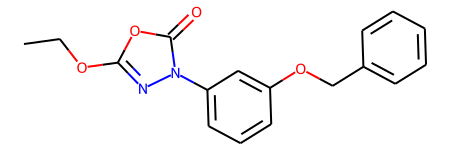

In [14]:
Chem.MolFromSmiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1')

In [15]:
df = pd.concat([df, df_lipinski], axis=1)
df

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.8032,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.5546,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.3574,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.7069,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.0953,0.0,6.0
...,...,...,...,...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1,266000.0,inactive,306.406,2.7027,2.0,4.0
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,740.0,active,436.489,4.5050,1.0,7.0
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,510.0,active,331.441,3.2431,1.0,5.0
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,125000.0,inactive,447.506,5.1143,1.0,5.0


In [16]:
def cap_standard_values(data):
    '''
    Cap IC50 values to 100_000_000 for log transformation
    '''
    norm = []

    for val in data['standard_value']:
        if val > 100_000_000:
          val = 100_000_000
        norm.append(val)

    data['standard_value_norm'] = norm
    x = data.drop(columns='standard_value')
        
    return x

In [17]:
def conv_to_pIC50(data):
    pIC50 = []
    for val in data['standard_value_norm']:
        molar = val*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    data['pIC50'] = pIC50
    x = data.drop(columns='standard_value_norm')
        
    return x

In [18]:
df = cap_standard_values(df)
df = conv_to_pIC50(df)
df

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1,inactive,306.406,2.7027,2.0,4.0,3.575118
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,active,436.489,4.5050,1.0,7.0,6.130768
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,active,331.441,3.2431,1.0,5.0,6.292430
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,inactive,447.506,5.1143,1.0,5.0,3.903090


In [19]:
if PLOTTING_FLAG:
    sns.pairplot(data=df, hue='class', corner=True)
    plt.show()

In [20]:
df_2class = df[df['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1,inactive,306.406,2.7027,2.0,4.0,3.575118
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,active,436.489,4.5050,1.0,7.0,6.130768
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,active,331.441,3.2431,1.0,5.0,6.292430
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,inactive,447.506,5.1143,1.0,5.0,3.903090


In [21]:
df['class'].value_counts()

active          2236
inactive        1627
intermediate    1240
Name: class, dtype: int64

In [22]:
if PLOTTING_FLAG:
    plt.figure(figsize=(5.5, 5.5))

    sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

    plt.xlabel('MW', fontsize=14, fontweight='bold')
    plt.ylabel('LogP', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

In [23]:
def mannwhitney(descriptor):
    # actives and inactives
    selection = [descriptor, 'class']
    df = df_2class[selection]
    active = df[df['class'] == 'active']
    active = active[descriptor]

    selection = [descriptor, 'class']
    df = df_2class[selection]
    inactive = df[df['class'] == 'inactive']
    inactive = inactive[descriptor]

    # compare samples
    stat, p = scipy.stats.mannwhitneyu(active, inactive)

    # interpret
    alpha = 0.05
    if p > alpha:
      interpretation = 'Same distribution (fail to reject H0)'
    else:
      interpretation = 'Different distribution (reject H0)'

    results = pd.DataFrame({'Descriptor':descriptor,
                            'Statistics':stat,
                            'p':p,
                            'alpha':alpha,
                            'Interpretation':interpretation
                            },
                          index=[0]
                          )

    return results

In [24]:
if PLOTTING_FLAG:
    plt.figure(figsize=(5.5, 5.5))

    sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

    plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
    plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')
    plt.show()

In [25]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,3637972.0,0.0,0.05,Different distribution (reject H0)


In [26]:
if PLOTTING_FLAG:
    plt.figure(figsize=(5.5, 5.5))

    sns.boxplot(x = 'class', y = 'MW', data = df_2class)

    plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
    plt.ylabel('MW', fontsize=14, fontweight='bold')
    plt.show()

In [27]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,2377439.0,7.525552e-60,0.05,Different distribution (reject H0)


In [28]:
if PLOTTING_FLAG:
    plt.figure(figsize=(5.5, 5.5))

    sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

    plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
    plt.ylabel('LogP', fontsize=14, fontweight='bold')

    plt.show()

In [29]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,2427121.5,1.247187e-70,0.05,Different distribution (reject H0)


In [30]:
if PLOTTING_FLAG:
    plt.figure(figsize=(5.5, 5.5))

    sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

    plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
    plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

    plt.show()

In [31]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,2068562.0,1.958353e-14,0.05,Different distribution (reject H0)


In [32]:
if PLOTTING_FLAG:
    plt.figure(figsize=(5.5, 5.5))

    sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

    plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
    plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

    plt.show()

In [33]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1935770.5,0.000523,0.05,Different distribution (reject H0)


In [34]:
# PART 3

In [35]:
selection = ['canonical_smiles','molecule_chembl_id']
df[selection].to_csv('molecule.smi', sep='\t', index=False, header=False)

In [36]:
! wget -O padel.sh  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
! wget -O padel.zip https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [37]:
! unzip -o padel.zip
! rm -rf padel.zip __MACOSX

'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [38]:
# 2m - Desktop
if GEN_FINGERPRINTS:
    ! bash padel.sh

'bash' is not recognized as an internal or external command,
operable program or batch file.


In [39]:
x = pd.read_csv('descriptors_output.csv')
x.drop(columns='Name', inplace=True)
x = x.loc[:, x.var() != 0]
x

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP28,PubchemFP30,PubchemFP31,PubchemFP33,PubchemFP34,PubchemFP37,PubchemFP38,PubchemFP39,PubchemFP43,PubchemFP44,PubchemFP46,PubchemFP47,PubchemFP66,PubchemFP115,PubchemFP116,PubchemFP118,PubchemFP129,PubchemFP130,PubchemFP131,PubchemFP132,PubchemFP143,PubchemFP144,PubchemFP145,PubchemFP146,PubchemFP147,PubchemFP148,PubchemFP149,PubchemFP150,PubchemFP151,PubchemFP152,PubchemFP153,PubchemFP154,PubchemFP155,PubchemFP156,PubchemFP157,PubchemFP159,PubchemFP160,PubchemFP164,PubchemFP166,PubchemFP167,PubchemFP171,PubchemFP173,PubchemFP174,PubchemFP178,PubchemFP179,PubchemFP180,PubchemFP181,PubchemFP182,PubchemFP183,PubchemFP184,PubchemFP185,PubchemFP186,PubchemFP187,PubchemFP188,PubchemFP189,PubchemFP190,PubchemFP191,PubchemFP192,PubchemFP193,PubchemFP194,PubchemFP195,PubchemFP197,PubchemFP198,PubchemFP199,PubchemFP200,PubchemFP201,PubchemFP202,PubchemFP206,PubchemFP207,PubchemFP209,PubchemFP213,PubchemFP214,PubchemFP215,PubchemFP216,PubchemFP217,PubchemFP218,PubchemFP219,PubchemFP220,PubchemFP221,PubchemFP222,PubchemFP223,PubchemFP227,PubchemFP228,PubchemFP229,PubchemFP230,PubchemFP241,PubchemFP243,PubchemFP244,PubchemFP248,PubchemFP250,PubchemFP251,PubchemFP255,PubchemFP256,PubchemFP257,PubchemFP258,PubchemFP259,PubchemFP260,PubchemFP261,PubchemFP262,PubchemFP283,PubchemFP284,PubchemFP285,PubchemFP286,PubchemFP287,PubchemFP291,PubchemFP292,PubchemFP293,PubchemFP294,PubchemFP296,PubchemFP297,PubchemFP298,PubchemFP299,PubchemFP300,PubchemFP301,PubchemFP304,PubchemFP305,PubchemFP308,PubchemFP314,PubchemFP316,PubchemFP327,PubchemFP328,PubchemFP329,PubchemFP330,PubchemFP331,PubchemFP332,PubchemFP333,PubchemFP334,PubchemFP335,PubchemFP336,PubchemFP337,PubchemFP338,PubchemFP339,PubchemFP340,PubchemFP341,PubchemFP342,PubchemFP343,PubchemFP344,PubchemFP345,PubchemFP346,PubchemFP347,PubchemFP348,PubchemFP349,PubchemFP350,PubchemFP351,PubchemFP352,PubchemFP353,PubchemFP354,PubchemFP355,PubchemFP356,PubchemFP357,PubchemFP358,PubchemFP359,PubchemFP360,PubchemFP361,PubchemFP362,PubchemFP363,PubchemFP364,PubchemFP365,PubchemFP366,PubchemFP367,PubchemFP368,PubchemFP369,PubchemFP370,PubchemFP371,PubchemFP372,PubchemFP373,PubchemFP374,PubchemFP375,PubchemFP376,PubchemFP377,PubchemFP378,PubchemFP379,PubchemFP380,PubchemFP381,PubchemFP382,PubchemFP383,PubchemFP384,PubchemFP385,PubchemFP386,PubchemFP387,PubchemFP388,PubchemFP389,PubchemFP390,PubchemFP391,PubchemFP392,PubchemFP393,PubchemFP394,PubchemFP395,PubchemFP396,PubchemFP397,PubchemFP398,PubchemFP399,PubchemFP400,PubchemFP401,PubchemFP403,PubchemFP404,PubchemFP405,PubchemFP406,PubchemFP407,PubchemFP409,PubchemFP410,PubchemFP411,PubchemFP412,PubchemFP413,PubchemFP414,PubchemFP415,PubchemFP416,PubchemFP417,PubchemFP418,PubchemFP419,PubchemFP420,PubchemFP421,PubchemFP422,PubchemFP423,PubchemFP425,PubchemFP427,PubchemFP428,PubchemFP429,PubchemFP430,PubchemFP431,PubchemFP432,PubchemFP434,PubchemFP435,PubchemFP436,PubchemFP437,PubchemFP438,PubchemFP439,PubchemFP440,PubchemFP441,PubchemFP442,PubchemFP443,PubchemFP445,PubchemFP446,PubchemFP447,PubchemFP448,PubchemFP449,PubchemFP450,PubchemFP451,PubchemFP452,PubchemFP453,PubchemFP454,PubchemFP455,PubchemFP456,PubchemFP457,PubchemFP458,PubchemFP459,PubchemFP460,PubchemFP461,PubchemFP462,PubchemFP464,PubchemFP465,PubchemFP466,PubchemFP467,PubchemFP470,PubchemFP471,PubchemFP472,PubchemFP473,PubchemFP474,PubchemFP475,PubchemFP476,PubchemFP477,PubchemFP478,PubchemFP479,PubchemFP480,PubchemFP481,PubchemFP482,PubchemFP483,PubchemFP484,PubchemFP485,PubchemFP486,PubchemFP487,PubchemFP488,PubchemFP489,PubchemFP490,PubchemFP491,PubchemFP492,PubchemFP493,PubchemFP494,PubchemFP495,PubchemFP496,PubchemFP497,PubchemFP498,PubchemFP499,PubchemFP500,PubchemFP501,PubchemFP502,PubchemFP503,PubchemFP504,PubchemFP505,PubchemF

In [40]:
y = df['pIC50']
y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
5098    3.575118
5099    6.130768
5100    6.292430
5101    3.903090
5102    4.000000
Name: pIC50, Length: 5103, dtype: float64

In [41]:
# n_comps = 2
# mapper = umap.UMAP(
#     n_components = n_comps,
# )
# mapper.fit(x)
# temp = pd.DataFrame(mapper.transform(x), columns=[f'UMAP{i}' for i in range(1, n_comps+1)])
# plt.figure(figsize=(15,12))
# sns.scatterplot(data=pd.concat([temp, y], axis=1), x='UMAP1', y='UMAP2', hue='pIC50', s=20)
# plt.show()

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [43]:
x_train.shape, y_train.shape

((4082, 634), (4082,))

In [44]:
x_test.shape, y_test.shape

((1021, 634), (1021,))

In [45]:
models = {
    'LinReg' : LinearRegression(),
    'DTree'  : DecisionTreeRegressor(),
    'RFrst'  : RandomForestRegressor(),
    'KNN'    : KNeighborsRegressor(),
    'SVM'    : SVR(),
    'LGBM'   : LGBMRegressor(),
    'XGBR'   : XGBRegressor(use_label_encoder=False, eval_metric='logloss'),
    'NeuNet' : MLPRegressor(hidden_layer_sizes=(100,100,100), max_iter=100_000),
    'Hist'   : HistGradientBoostingRegressor(),
    'CatBst' : CatBoostRegressor(allow_writing_files=False, verbose=False),
}

In [46]:
print(f'Name\tScore\tTime')
for name,model in models.items():
    t0 = perf_counter()
    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)
    t1 = perf_counter()
    print(f'{name}\t{score:.3f}\t{(t1-t0):.2f}s')

Name	Score	Time
LinReg	-13915921367766614016.000	0.13s
DTree	-0.258	0.23s
RFrst	0.227	11.01s
KNN	0.190	0.10s
SVM	0.211	5.58s
LGBM	0.257	0.16s
XGBR	0.216	2.24s
NeuNet	0.054	12.12s
Hist	0.257	9.35s
CatBst	0.249	11.79s


In [47]:
preds = models['CatBst'].predict(x_test)

In [48]:
if PLOTTING_FLAG:
    plt.figure(figsize=(12,10))
    sns.regplot(y_test, preds, scatter_kws={'alpha':0.4})
    plt.plot([0,12], [0,12], color='Black')
    plt.xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
    plt.ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
    plt.xlim(0); plt.ylim(0); plt.grid(); plt.show()

In [49]:
from sklearn.model_selection import KFold, GridSearchCV

In [50]:
from sklearn.preprocessing import QuantileTransformer

In [51]:
scalar = QuantileTransformer(output_distribution='normal')
scalar.fit(y_train.values.reshape(-1,1))

QuantileTransformer(output_distribution='normal')

In [52]:
y_train = pd.Series(scalar.transform(y_train.values.reshape(-1,1)).reshape(-1), name='pIC50')
y_test  = pd.Series(scalar.transform(y_test.values.reshape(-1,1)).reshape(-1),  name='pIC50')

In [53]:
if PLOTTING_FLAG:
    y_train.hist(bins=50)
    plt.show()

In [54]:
# 6m
params = {'hidden_layer_sizes' : [
    (100,),        (250,),        (500,),
    (50,50),       (100,100),     (200,200),     (100,50),      (200,100),     (300,150),
    (100,100,100), (200,200,200), (200,100,50),  (300,150,50)
    ]
}

model = MLPRegressor(max_iter=100_000)

metric = 'f1'
fold = KFold(n_splits=5, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=params, cv=fold, verbose=2)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] END ..........................hidden_layer_sizes=(100,); total time=   6.2s
[CV] END ..........................hidden_layer_sizes=(100,); total time=   7.5s
[CV] END ..........................hidden_layer_sizes=(100,); total time=  11.7s
[CV] END ..........................hidden_layer_sizes=(100,); total time=   7.6s
[CV] END ..........................hidden_layer_sizes=(100,); total time=   7.8s
[CV] END ..........................hidden_layer_sizes=(250,); total time=  20.7s
[CV] END ..........................hidden_layer_sizes=(250,); total time=  20.7s
[CV] END ..........................hidden_layer_sizes=(250,); total time=  22.6s
[CV] END ..........................hidden_layer_sizes=(250,); total time=  21.8s
[CV] END ..........................hidden_layer_sizes=(250,); total time=  22.7s
[CV] END ..........................hidden_layer_sizes=(500,); total time=  26.1s
[CV] END ..........................hidden_layer_

C:\Users\k1890928\Miniconda3\envs\cdd_intro\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END ......................hidden_layer_sizes=(100, 100); total time=   5.4s
[CV] END ......................hidden_layer_sizes=(100, 100); total time=   7.9s


In [ ]:
grid.cv_results_